## Softmax Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set, onehot_encode, onehot_decode, z_score_normalize
from model.softmax import SoftmaxRegression

In [2]:
#Q6(a) - Evaluate Network on all 43 traffic signs (aligned dataset)

# Load aligned data
X, y = traffic_sign(True)
X = X.astype(np.float32) # cast to float32 as float64 running out of memory
X = z_score_normalize(X) 

print(X.shape)
print(y.shape)
print(X.dtype)
print(y.dtype)

(34799, 1024)
(34799,)
float32
uint8


**********
(27841, 1024)
[1023 1022 1021 ...    2    1    0]
bruh1: (1024,)
bruh (27841, 1024)
bruh3 (27841, 1024)
(27841, 100)


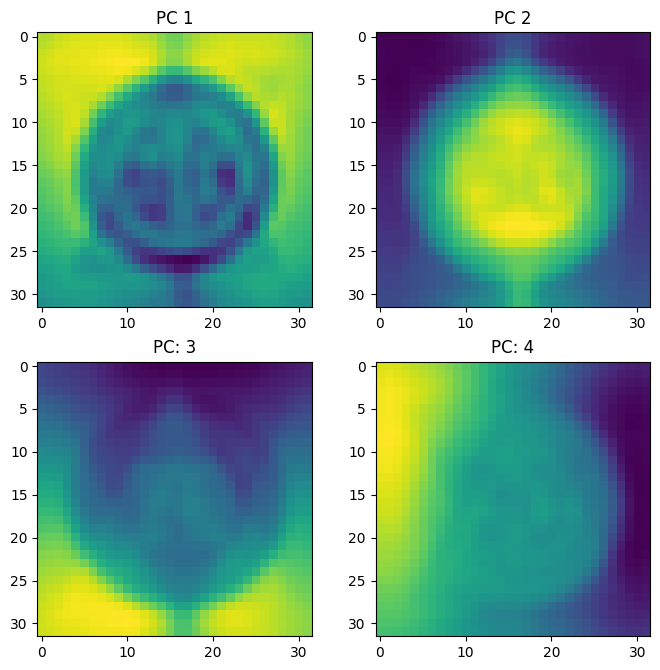

 epoch: 1, train accuracy: 0.004956718508674258,               train_loss_ex:3.761200115693563, train_loss_class: 2435.245870256383
 epoch: 2, train accuracy: 0.6597464171545562,               train_loss_ex:3.7366346096321252, train_loss_class: 2419.3405620178605
 epoch: 3, train accuracy: 0.6597464171545562,               train_loss_ex:3.7121857755491887, train_loss_class: 2403.510794815464
 epoch: 4, train accuracy: 0.6597464171545562,               train_loss_ex:3.6878566285390493, train_loss_class: 2387.7585208175738
 epoch: 5, train accuracy: 0.6597464171545562,               train_loss_ex:3.663650394793163, train_loss_class: 2372.085828870615
 epoch: 6, train accuracy: 0.6597464171545562,               train_loss_ex:3.639570519115105, train_loss_class: 2356.494949364736
 epoch: 7, train accuracy: 0.6597464171545562,               train_loss_ex:3.615620671391707, train_loss_class: 2340.9882584236398
 epoch: 8, train accuracy: 0.6597823354046191,               train_loss_ex:3.59180

 epoch: 66, train accuracy: 0.6698394454222191,               train_loss_ex:2.566560866176244, train_loss_class: 1661.758629656112
 epoch: 67, train accuracy: 0.6699831184224705,               train_loss_ex:2.5552343285159775, train_loss_class: 1654.4250916328683
 epoch: 68, train accuracy: 0.6703063826730362,               train_loss_ex:2.544071446448308, train_loss_class: 1647.197514896915
 epoch: 69, train accuracy: 0.6704500556732876,               train_loss_ex:2.533068889340411, train_loss_class: 1640.0737429796834
 epoch: 70, train accuracy: 0.6707374016737905,               train_loss_ex:2.522223380243432, train_loss_class: 1633.0516541711022
 epoch: 71, train accuracy: 0.6710606659243562,               train_loss_ex:2.5115316978692275, train_loss_class: 1626.1291627994688
 epoch: 72, train accuracy: 0.6712402571746704,               train_loss_ex:2.500990678210245, train_loss_class: 1619.3042202802658
 epoch: 73, train accuracy: 0.6715635214252361,               train_loss_ex:

 epoch: 131, train accuracy: 0.6898459107072303,               train_loss_ex:2.0626284773103807, train_loss_class: 1335.4799869022863
 epoch: 132, train accuracy: 0.6902410114579217,               train_loss_ex:2.05732411338627, train_loss_class: 1332.0455962973756
 epoch: 133, train accuracy: 0.6907438669588017,               train_loss_ex:2.0520681976916237, train_loss_class: 1328.6425742309884
 epoch: 134, train accuracy: 0.6908516217089904,               train_loss_ex:2.0468599890584533, train_loss_class: 1325.270440822707
 epoch: 135, train accuracy: 0.6910671312093675,               train_loss_ex:2.041698762083681, train_loss_class: 1321.928726399343
 epoch: 136, train accuracy: 0.6914981502101217,               train_loss_ex:2.0365838067096393, train_loss_class: 1318.6169712233273
 epoch: 137, train accuracy: 0.6918573327107503,               train_loss_ex:2.031514427817372, train_loss_class: 1315.3347252293827
 epoch: 138, train accuracy: 0.6922524334614417,               train

 epoch: 192, train accuracy: 0.7064401422362703,               train_loss_ex:1.807343646783259, train_loss_class: 1170.1919644207608
 epoch: 193, train accuracy: 0.706763406486836,               train_loss_ex:1.8040448112785201, train_loss_class: 1168.0560835070994
 epoch: 194, train accuracy: 0.7069429977371502,               train_loss_ex:1.8007677806144908, train_loss_class: 1165.9343204671636
 epoch: 195, train accuracy: 0.7073380984878417,               train_loss_ex:1.7975123134353237, train_loss_class: 1163.8265190314617
 epoch: 196, train accuracy: 0.7073380984878417,               train_loss_ex:1.7942781721430834, train_loss_class: 1161.7325253636184
 epoch: 197, train accuracy: 0.7074099349879673,               train_loss_ex:1.7910651228225036, train_loss_class: 1159.6521880116586
 epoch: 198, train accuracy: 0.7075536079882189,               train_loss_ex:1.7878729351675762, train_loss_class: 1157.5853578604765
 epoch: 199, train accuracy: 0.7076613627384074,               t

 epoch: 254, train accuracy: 0.7213462160123558,               train_loss_ex:1.636621908387712, train_loss_class: 1059.655594219123
 epoch: 255, train accuracy: 0.7219209080133616,               train_loss_ex:1.6343280411311665, train_loss_class: 1058.170395189135
 epoch: 256, train accuracy: 0.7222082540138645,               train_loss_ex:1.6320460406169484, train_loss_class: 1056.692879460848
 epoch: 257, train accuracy: 0.722316008764053,               train_loss_ex:1.6297758045152217, train_loss_class: 1055.2229807792626
 epoch: 258, train accuracy: 0.7224237635142415,               train_loss_ex:1.6275172317392124, train_loss_class: 1053.7606336942188
 epoch: 259, train accuracy: 0.7227111095147445,               train_loss_ex:1.6252702224257782, train_loss_class: 1052.305773547816
 epoch: 260, train accuracy: 0.7228907007650587,               train_loss_ex:1.6230346779163485, train_loss_class: 1050.858336462071
 epoch: 261, train accuracy: 0.7229984555152473,               train_

 epoch: 16, train accuracy: 0.6606405768326454,               train_loss_ex:3.4064085781944087, train_loss_class: 3032.3373850261764
 epoch: 17, train accuracy: 0.6606667014995559,               train_loss_ex:3.3839949341850706, train_loss_class: 3012.3850718775843
 epoch: 18, train accuracy: 0.6607189508333768,               train_loss_ex:3.36176592877558, train_loss_class: 2992.597121434225
 epoch: 19, train accuracy: 0.6608234495010189,               train_loss_ex:3.3397274206079515, train_loss_class: 2972.978748977469
 epoch: 20, train accuracy: 0.6610063221693924,               train_loss_ex:3.3178852735562203, train_loss_class: 2953.5351744461627
 epoch: 21, train accuracy: 0.6611630701708553,               train_loss_ex:3.2962453061823247, train_loss_class: 2934.2715774429544
 epoch: 22, train accuracy: 0.6612675688384974,               train_loss_ex:3.2748132383482, train_loss_class: 2915.1930497091253
 epoch: 23, train accuracy: 0.6612675688384974,               train_loss_ex:

 epoch: 80, train accuracy: 0.6752965149694341,               train_loss_ex:2.419673301340508, train_loss_class: 2153.9594099700457
 epoch: 81, train accuracy: 0.6756100109723601,               train_loss_ex:2.4103193808628616, train_loss_class: 2145.6326804806654
 epoch: 82, train accuracy: 0.6758190083076441,               train_loss_ex:2.401087944105813, train_loss_class: 2137.414984290286
 epoch: 83, train accuracy: 0.6761586289774806,               train_loss_ex:2.3919765003290197, train_loss_class: 2129.3041041766096
 epoch: 84, train accuracy: 0.676498249647317,               train_loss_ex:2.3829826165275705, train_loss_class: 2121.2978743126127
 epoch: 85, train accuracy: 0.676707246982601,               train_loss_ex:2.3741039166452786, train_loss_class: 2113.394179566232
 epoch: 86, train accuracy: 0.6771513663200794,               train_loss_ex:2.3653380807197615, train_loss_class: 2105.590954739326
 epoch: 87, train accuracy: 0.6773342389884529,               train_loss_ex:

 epoch: 143, train accuracy: 0.6948638904853963,               train_loss_ex:1.9981638458977535, train_loss_class: 1778.737574262191
 epoch: 144, train accuracy: 0.6951773864883223,               train_loss_ex:1.993375550206143, train_loss_class: 1774.4751002509474
 epoch: 145, train accuracy: 0.6954125084905167,               train_loss_ex:1.9886280332652695, train_loss_class: 1770.2489269146042
 epoch: 146, train accuracy: 0.6957782538272637,               train_loss_ex:1.9839207168102826, train_loss_class: 1766.0585394898606
 epoch: 147, train accuracy: 0.6961178744971002,               train_loss_ex:1.9792530340451504, train_loss_class: 1761.903433422797
 epoch: 148, train accuracy: 0.6964313705000261,               train_loss_ex:1.974624429353235, train_loss_class: 1757.7831141112354
 epoch: 149, train accuracy: 0.6966926171691311,               train_loss_ex:1.9700343580164787, train_loss_class: 1753.6970966547622
 epoch: 150, train accuracy: 0.697058362505878,               trai

KeyboardInterrupt: 

In [3]:
# Softmax Regression Parameters
lr = 0.1
num_features = X.shape[1]
num_classes = y.max() + 1

train_loss_record = []
train_accuracy_record = []
holdout_loss_record = []
holdout_accuracy_record = []
test_accuracy_record = []


# PCA number of principal components
n_components = 100

first_plot = True

num_epochs = 300
epochs_print = [50, 100, 150, 200, 250, 300]

for train, valid, test in generate_k_fold_set((X, y), 10):
    print("**********")
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    
    print(train_data.shape)
    # Project data onto principal components
    pca = PCA(n_components)
    projected = pca.fit_transform(train_data)
    print(projected.shape)
    
    # Plot principal components
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = projected     
    valid_d = pca.PCA_generate(valid_data)
    test_d = pca.PCA_generate(test_data)

    softmax_model = SoftmaxRegression(lr, n_components, num_classes)
    
    # Onehot encode labels
    y_true = onehot_encode(train_label)
    
    for epoch in range(num_epochs):
        y_hat = softmax_model.model(train_d)
        
        raw_train_loss = softmax_model.cross_entropy(y_true, y_hat)
        train_loss_ex = raw_train_loss / len(train_d) # train loss per example
        train_loss_class = raw_train_loss / num_classes # train loss per class
        
        train_loss_record.append(raw_train_loss)
        
        train_accuracy = softmax_model.accuracy(y_true, y_hat)
        train_accuracy_record.append(train_accuracy)
        
        # Update Weights
        softmax_model.update_weights(train_d, y_true, y_hat)
        
        if (epoch + 1) in epochs_print:
            print(f' epoch: {epoch + 1}, train accuracy: {train_accuracy}, \
                  train_loss_ex:{train_loss_ex}, train_loss_class: {train_loss_class}')
